In [2]:
from ocpmodels.datasets import LmdbDataset as LD
import matplotlib.pyplot as plt
import scipy
import lmdb
import ase
import pickle
import torch
import os
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import re
import warnings
warnings.filterwarnings("ignore")

In [3]:
## get mappings of sid (a random number) to systems (adslabs) that are in the OC20 dataset 
with open("oc20_data_mapping.pkl", "rb") as input_file:
    mappings = pickle.load(input_file)
## get mappings of sid (a random number) to systems (adslabs) that are in the OC20 dataset 
with open("oc20_ref.pkl", "rb") as input_file:
    ref_mappings = pickle.load(input_file)

In [4]:
df_val_id = pd.read_csv("val_sets_with_anomalies/val_id_30k_anomalies.csv", index_col=0) 
df_ood_cat = pd.read_csv("val_sets_with_anomalies/val_ood_cat_30k_anomalies.csv", index_col=0)
df_ood_ads = pd.read_csv("val_sets_with_anomalies/val_ood_ads_30k_anomalies.csv", index_col=0)
df_ood_both = pd.read_csv("val_sets_with_anomalies/val_ood_both_30k_anomalies.csv", index_col=0)

In [5]:
for df in [df_val_id,df_ood_cat,df_ood_ads,df_ood_both]:
    material_classes = []
    surfaces = []
    adsorbates = []
    for i in tqdm(df["sid"].values):
        material_classes.append(mappings[i]["class"])
        surfaces.append(mappings[i]["bulk_symbols"])
        adsorbates.append(mappings[i]["ads_symbols"])
    material_classes = np.array(material_classes)
    # add system information to the dataframe
    df["cat_class"] = material_classes
    df["bulk_symbols"] = surfaces
    df["ads_symbols"] = adsorbates

100%|██████████| 30000/30000 [00:00<00:00, 692937.42it/s]


In [8]:
# goc linear referencing inference
inference_path = "/home/jovyan/shared-scratch/kabdelma/oc20_data_quality_project/s2ef_200k_experiment/remove_anomalies/"
pred_path = inference_path + "results/2024-03-07-18-03-44-goc_20_22_lin_ref_val_id/s2ef_predictions.npz"
val_id_predictions = np.load(pred_path)

In [9]:
pred_path = inference_path + "results/2024-03-07-18-16-32-goc_20_22_lin_ref_val_ood_cat/s2ef_predictions.npz"
val_ood_cat_predictions = np.load(pred_path)

In [10]:
pred_path = inference_path + "results/2024-03-07-18-10-08-goc_20_22_lin_ref_val_ood_ads/s2ef_predictions.npz"
val_ood_ads_predictions = np.load(pred_path)

In [11]:
pred_path = inference_path + "results/2024-03-07-18-22-56-goc_20_22_lin_ref_val_ood_both/s2ef_predictions.npz"
val_ood_both_predictions = np.load(pred_path)

In [12]:
val_id_preds_goc = []
for i in tqdm(range(len(df_val_id))):
    sid_fid = df_val_id.iloc[i]["sid"][6:] + "_" +  str(df_val_id.iloc[i]["fid"])
    val_id_preds_goc.append(val_id_predictions["energy"][np.where(val_id_predictions["ids"]==sid_fid)[0]][0])

100%|██████████| 30000/30000 [02:53<00:00, 172.70it/s]


In [13]:
val_ood_cat_preds_goc = []
for i in tqdm(range(len(df_ood_cat))):
    sid_fid = df_ood_cat.iloc[i]["sid"][6:] + "_" + str(df_ood_cat.iloc[i]["fid"])
    val_ood_cat_preds_goc.append(val_ood_cat_predictions["energy"][np.where(val_ood_cat_predictions["ids"]==sid_fid)[0]][0])

100%|██████████| 30000/30000 [02:53<00:00, 172.46it/s]


In [14]:
val_ood_ads_preds_goc = []
for i in tqdm(range(len(df_ood_ads))):
    sid_fid = df_ood_ads.iloc[i]["sid"][6:] + "_" + str(df_ood_ads.iloc[i]["fid"])
    val_ood_ads_preds_goc.append(val_ood_ads_predictions["energy"][np.where(val_ood_ads_predictions["ids"]==sid_fid)[0]][0])

100%|██████████| 30000/30000 [02:57<00:00, 168.92it/s]


In [15]:
val_ood_both_preds_goc = []
for i in tqdm(range(len(df_ood_both))):
    sid_fid = df_ood_both.iloc[i]["sid"][6:] + "_" + str(df_ood_both.iloc[i]["fid"])
    val_ood_both_preds_goc.append(val_ood_both_predictions["energy"][np.where(val_ood_both_predictions["ids"]==sid_fid)[0]][0])

100%|██████████| 30000/30000 [02:50<00:00, 175.58it/s]


In [16]:
total_energy_ref = []
for i in tqdm(range(len(df_val_id))):
    sid = df_val_id.iloc[i]["sid"]
    total_energy_ref.append(ref_mappings[sid])

100%|██████████| 30000/30000 [00:03<00:00, 9140.23it/s]


In [17]:
df_val_id["dft_total_energy"] = df_val_id["ref_energies"] + total_energy_ref
df_val_id["total_energy_pred"] = val_id_preds_goc

,sid,fid,ref_energies,surface_anomalies,adsorbate_dissociated_anomalies,adsorbate_desorbed_anomalies,cat_class,bulk_symbols,ads_symbols,val_id_goc,val_id_eqv2,val_id_escn,goc_forces_maes,escn_forces_maes,eqv2_forces_maes,dft_total_energy,total_energy_pred
0,random2163697,34,-0.866727,0,0,1,2,SnPbSe2,*CHOCH2OH,-1.0750,-1.0240,-1.0110,0.015447,0.010043,0.009077,-156.791327,-156.930756
1,random2099289,25,-1.864362,0,0,0,0,Ti3Ga,*OHCH3,-1.8640,-1.8970,-1.8930,0.012776,0.012838,0.010518,-465.724453,-465.786194
2,random1899087,116,-1.309746,0,0,0,1,Ge8Mo4,*OCH2CHOH,-1.3520,-1.3640,-1.3200,0.039622,0.029826,0.030165,-484.423186,-484.430298
3,random2242031,38,-1.562169,0,0,0,1,V10Si6,*ONN(CH3)2,-1.5500,-1.5760,-1.5540,0.012542,0.013048,0.009500,-997.845310,-997.952087
4,random452544,739,-3.829937,0,1,0,2,N12Al4Ca12,*OH2,-3.8400,-4.5200,-4.1700,0.006008,0.007014,0.006463,-460.698346,-460.720184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,random1405445,181,-0.722562,0,0,0,2,Na4Se4Pt2,*CH*CH,-0.6655,-0.8413,-0.6436,0.024341,0.015965,0.011855,-228.259424,-228.269669
29996,random1159418,50,-3.723823,0,0,0,0,Al8Hf12,CH2*CO,-3.8950,-3.7520,-3.7540,0.021861,0.015483,0.013978,-865.898132,-866.314758
29997,random1906766,221,4.258890,0,0,0,1,Sb8Ir4,*NO2,4.2660,4.2600,4.2660,0.005737,0.005343,0.005286,-393.193659,-393.259644
29998,random1850524,307,-1.782513,0,0,0,0,AlScCu2,*CCHO,-1.7850,-1.7640,-1.7540,0.007241,0.005780,0.006117,-355.644733,-355.584717


In [18]:
id_mae = np.mean(np.abs(df_val_id["dft_total_energy"] - df_val_id["total_energy_pred"]))

id_no_surf_anom_mae = np.mean(np.abs(df_val_id.query("surface_anomalies!=1")["dft_total_energy"] \
- df_val_id.query("surface_anomalies!=1")["total_energy_pred"]))

id_no_ads_anom_mae = np.mean(np.abs(df_val_id.query("adsorbate_dissociated_anomalies!=1&adsorbate_desorbed_anomalies!=1")["dft_total_energy"] \
- df_val_id.query("adsorbate_dissociated_anomalies!=1&adsorbate_desorbed_anomalies!=1")["total_energy_pred"]))

In [19]:
total_energy_ref_ood_ads = []
for i in tqdm(range(len(df_ood_ads))):
    sid = df_ood_ads.iloc[i]["sid"]
    total_energy_ref_ood_ads.append(ref_mappings[sid])

100%|██████████| 30000/30000 [00:03<00:00, 9046.27it/s]


In [20]:
df_ood_ads["dft_total_energy"] = df_ood_ads["ref_energies"] + total_energy_ref_ood_ads
df_ood_ads["total_energy_pred"] = val_ood_ads_preds_goc

In [21]:
ood_ads_mae = np.mean(np.abs(df_ood_ads["dft_total_energy"] - df_ood_ads["total_energy_pred"]))

ood_ads_no_surf_anom_mae = np.mean(np.abs(df_ood_ads.query("surface_anomalies!=1")["dft_total_energy"] \
- df_ood_ads.query("surface_anomalies!=1")["total_energy_pred"]))

ood_ads_no_ads_anom_mae = np.mean(np.abs(df_ood_ads.query("adsorbate_dissociated_anomalies!=1&adsorbate_desorbed_anomalies!=1")["dft_total_energy"] \
- df_ood_ads.query("adsorbate_dissociated_anomalies!=1&adsorbate_desorbed_anomalies!=1")["total_energy_pred"]))

In [22]:
total_energy_ref_ood_cat = []
for i in tqdm(range(len(df_ood_cat))):
    sid = df_ood_cat.iloc[i]["sid"]
    total_energy_ref_ood_cat.append(ref_mappings[sid])

100%|██████████| 30000/30000 [00:03<00:00, 9247.34it/s]


In [23]:
df_ood_cat["dft_total_energy"] = df_ood_cat["ref_energies"] + total_energy_ref_ood_cat
df_ood_cat["total_energy_pred"] = val_ood_cat_preds_goc

In [24]:
ood_cat_mae = np.mean(np.abs(df_ood_cat["dft_total_energy"] - df_ood_cat["total_energy_pred"]))

ood_cat_no_surf_anom_mae = np.mean(np.abs(df_ood_cat.query("surface_anomalies!=1")["dft_total_energy"] \
- df_ood_cat.query("surface_anomalies!=1")["total_energy_pred"]))

ood_cat_no_ads_anom_mae = np.mean(np.abs(df_ood_cat.query("adsorbate_dissociated_anomalies!=1&adsorbate_desorbed_anomalies!=1")["dft_total_energy"] \
- df_ood_cat.query("adsorbate_dissociated_anomalies!=1&adsorbate_desorbed_anomalies!=1")["total_energy_pred"]))

In [25]:
total_energy_ref_ood_both = []
for i in tqdm(range(len(df_ood_both))):
    sid = df_ood_both.iloc[i]["sid"]
    total_energy_ref_ood_both.append(ref_mappings[sid])

100%|██████████| 30000/30000 [00:03<00:00, 9343.69it/s]


In [26]:
df_ood_both["dft_total_energy"] = df_ood_both["ref_energies"] + total_energy_ref_ood_both
df_ood_both["total_energy_pred"] = val_ood_both_preds_goc

In [27]:
ood_both_mae = np.mean(np.abs(df_ood_both["dft_total_energy"] - df_ood_both["total_energy_pred"]))

ood_both_no_surf_anom_mae = np.mean(np.abs(df_ood_both.query("surface_anomalies!=1")["dft_total_energy"] \
- df_ood_both.query("surface_anomalies!=1")["total_energy_pred"]))

ood_both_no_ads_anom_mae = np.mean(np.abs(df_ood_both.query("adsorbate_dissociated_anomalies!=1&adsorbate_desorbed_anomalies!=1")["dft_total_energy"] \
- df_ood_both.query("adsorbate_dissociated_anomalies!=1&adsorbate_desorbed_anomalies!=1")["total_energy_pred"]))

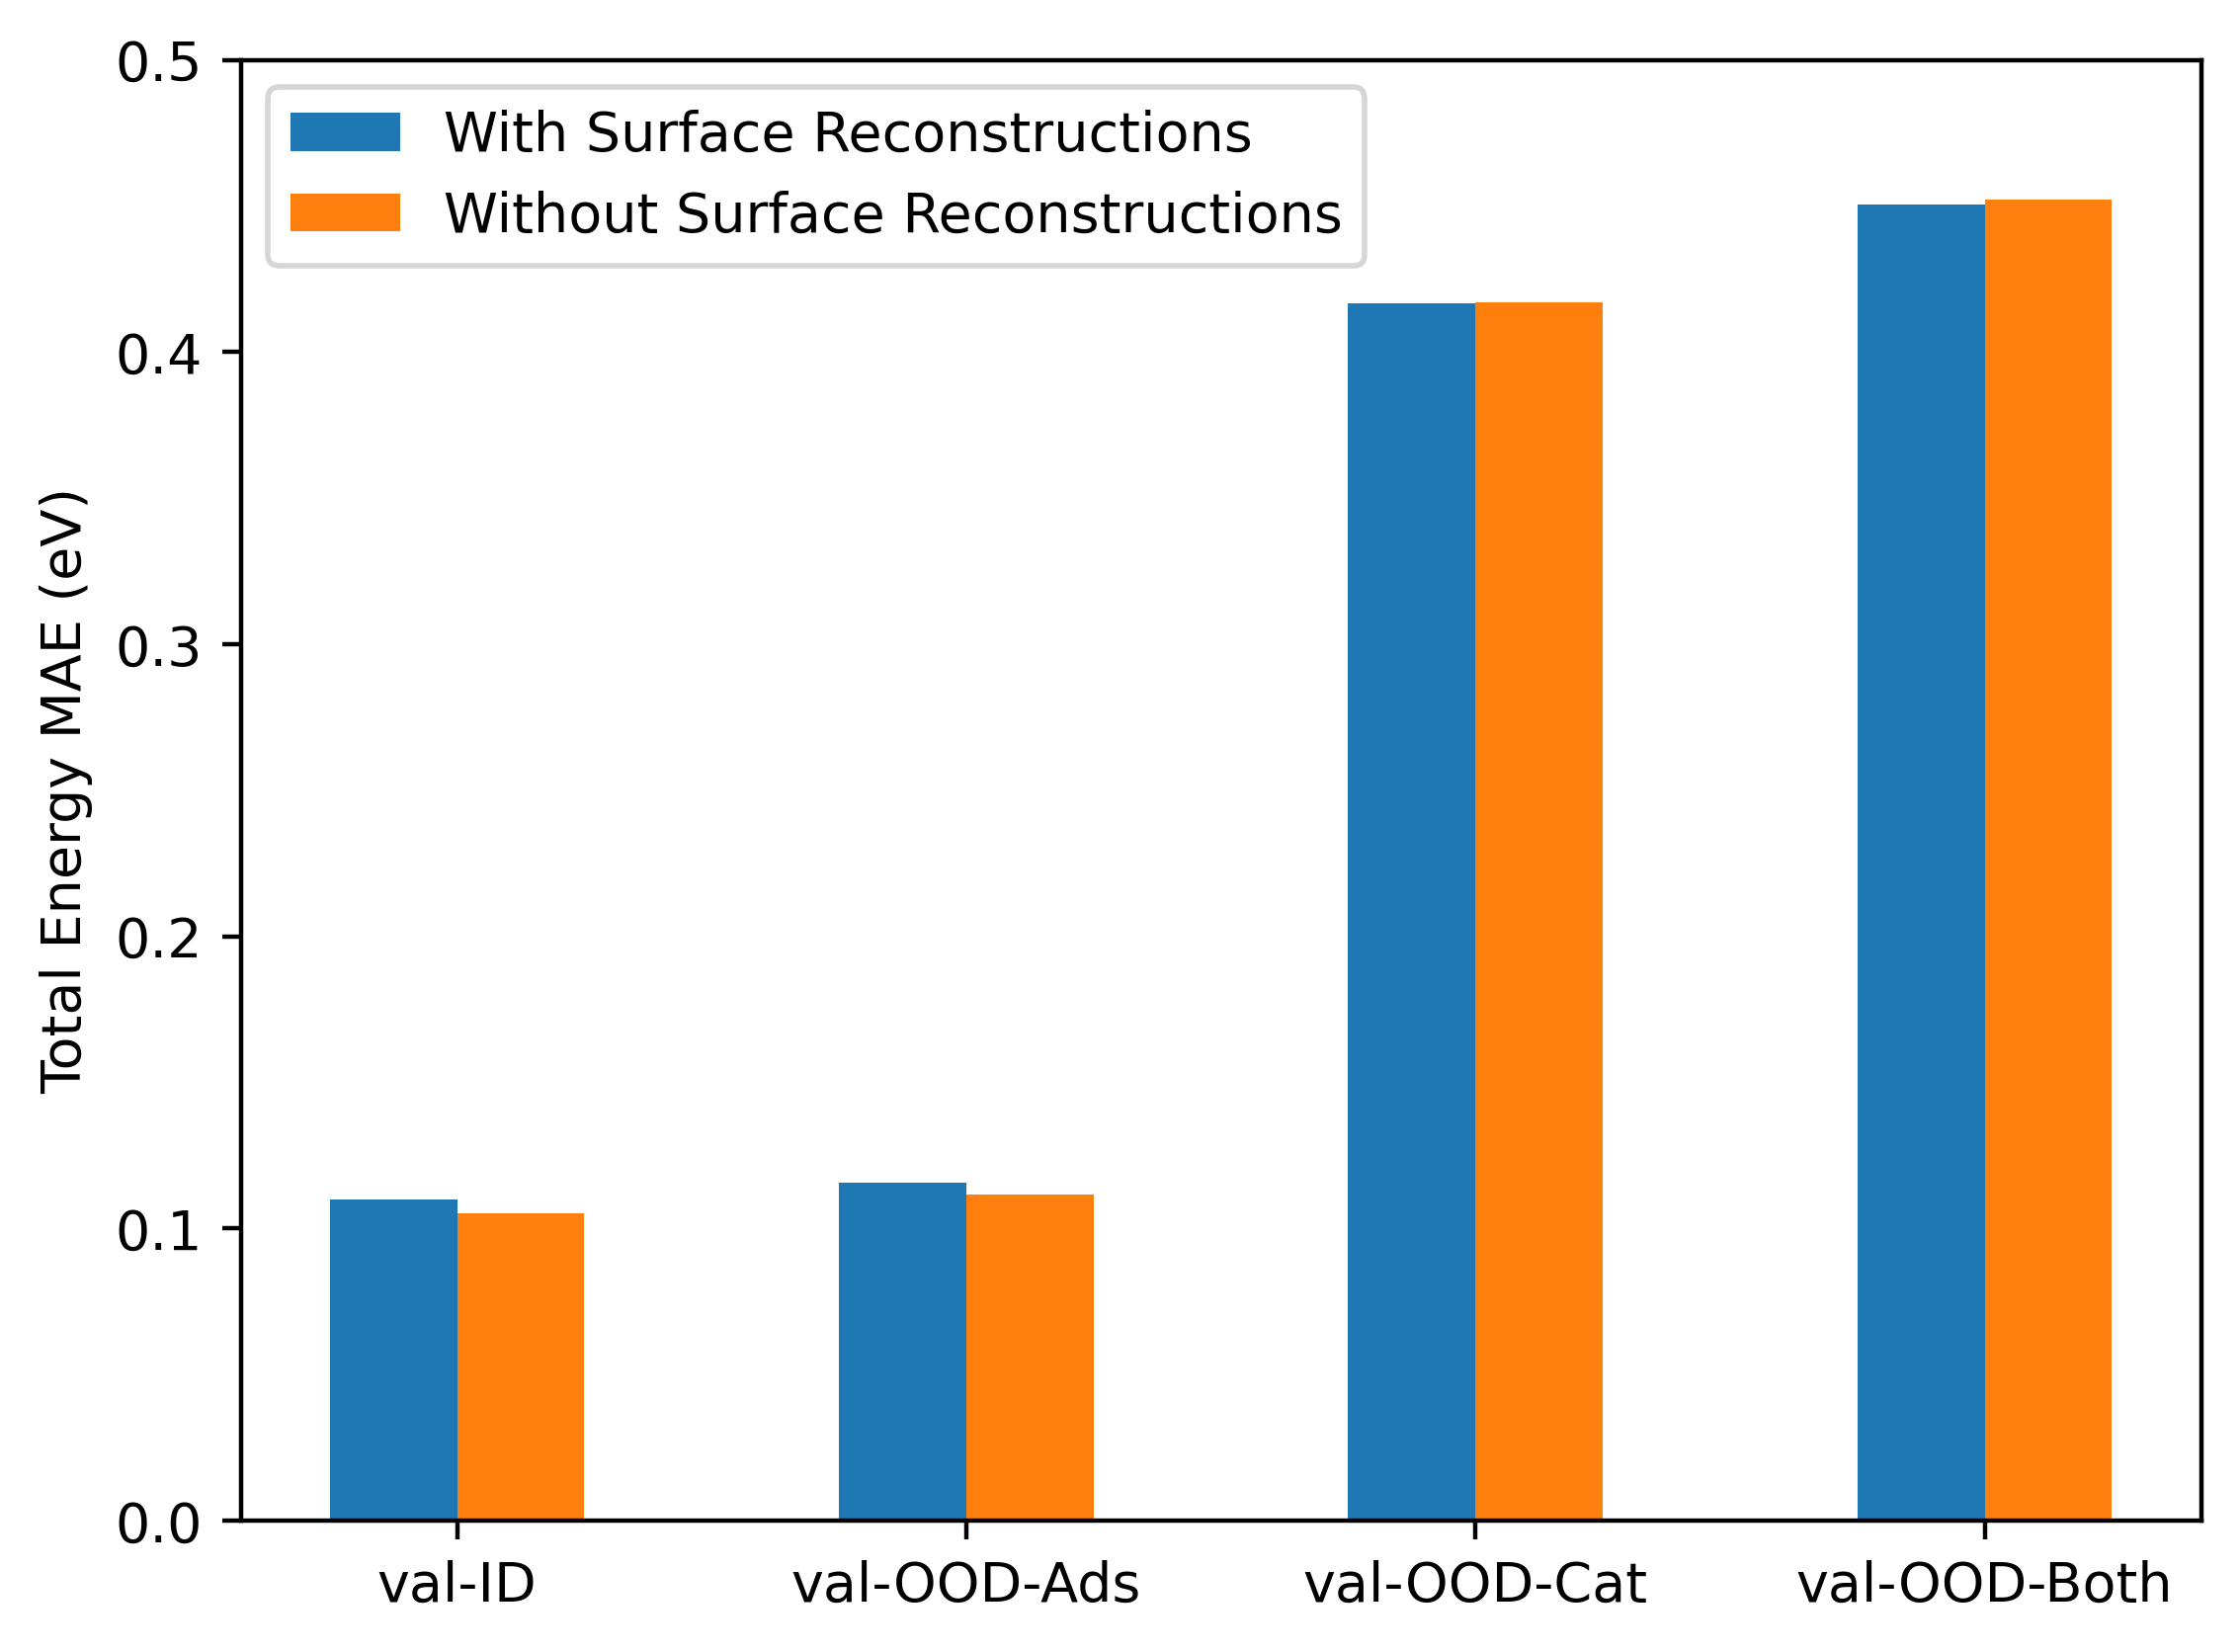

In [28]:
plt.figure(dpi=400)
val_sets = ["val-ID", "val-OOD-Ads", "val-OOD-Cat", "val-OOD-Both"]
original_maes = [id_mae, ood_ads_mae, ood_cat_mae, ood_both_mae]
surf_anom_maes = [id_no_surf_anom_mae, ood_ads_no_surf_anom_mae, ood_cat_no_surf_anom_mae, ood_both_no_surf_anom_mae]
ads_anom_maes = [id_no_ads_anom_mae, ood_ads_no_ads_anom_mae, ood_cat_no_ads_anom_mae, ood_both_no_ads_anom_mae]

# Set the width of the bars
bar_width = 0.25

# Set the positions of the bars on the x-axis
x_range = np.arange(len(original_maes))
r1 = x_range - bar_width/2
r2 = x_range
r3 = x_range + bar_width/2

# Plotting the bars
plt.bar(r1, original_maes, width=bar_width, label='With Surface Reconstructions')
plt.bar(r3, surf_anom_maes, width=bar_width, label='Without Surface Reconstructions')
# plt.bar(r3, ads_anom_maes, width=bar_width, label='Without Adsorbate Anomalies')

# Customizing xticks
plt.xticks(x_range, val_sets)

# Adding labels and title
plt.ylabel("Total Energy MAE (eV)")

# Adding legend
plt.legend()
plt.ylim(0,0.5)

# Show plot
plt.show()